This is supplemental code for Homework 4 for CMSC 491/691: Interactive Fiction and Text Generation. Specifically, this code is for running the planner Sabre.

Code taken from [a notebook](https://colab.research.google.com/github/apache/beam/blob/master/examples/notebooks/get-started/try-apache-beam-java.ipynb) for easily running Java in Colab. 😅 (I know it seems convoluted but I swear this is actually easier than fighting with individual computer problems.)

You can run this code without a GPU.


# Get the Sabre code from GitHub

In [1]:
!git clone https://github.com/sgware/sabre.git

Cloning into 'sabre'...
remote: Enumerating objects: 5827, done.
remote: Counting objects: 100% (5827/5827), done.
remote: Compressing objects: 100% (642/642), done.
remote: Total 5827 (delta 5150), reused 5716 (delta 5047), pack-reused 0 (from 0)
Receiving objects: 100% (5827/5827), 7.14 MiB | 7.82 MiB/s, done.
Resolving deltas: 100% (5150/5150), done.


# Setup Gradle/Java

In [2]:
def run(cmd):
  print('>> {}'.format(cmd))
  !{cmd}  # This is magic to run 'cmd' in the shell.
  print('')

In [3]:
run('apt-get update > /dev/null')
run('apt-get upgrade > /dev/null')

# Install the Java JDK.
run('apt-get install default-jdk > /dev/null')

# Check the Java version to see if everything is working well.
run('javac -version')

>> apt-get update > /dev/null
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)

>> apt-get upgrade > /dev/null
Extracting templates from packages: 100%

>> apt-get install default-jdk > /dev/null

>> javac -version
javac 11.0.25



In [4]:
import os

# Download the gradle source.
gradle_version = 'gradle-5.0'
gradle_path = f"/opt/{gradle_version}"
if not os.path.exists(gradle_path):
  run(f"wget -q -nc -O gradle.zip https://services.gradle.org/distributions/{gradle_version}-bin.zip")
  run('unzip -q -d /opt gradle.zip')
  run('rm -f gradle.zip')

# We're choosing to use the absolute path instead of adding it to the $PATH environment variable.
def gradle(args):
  run(f"{gradle_path}/bin/gradle --console=plain {args}")

gradle('-v')

>> wget -q -nc -O gradle.zip https://services.gradle.org/distributions/gradle-5.0-bin.zip

>> unzip -q -d /opt gradle.zip

>> rm -f gradle.zip

>> /opt/gradle-5.0/bin/gradle --console=plain -v

Welcome to Gradle 5.0!

Here are the highlights of this release:
 - Kotlin DSL 1.0
 - Task timeouts
 - Dependency alignment aka BOM support
 - Interactive `gradle init`

For more details see https://docs.gradle.org/5.0/release-notes.html


------------------------------------------------------------
Gradle 5.0
------------------------------------------------------------

Build time:   2018-11-26 11:48:43 UTC
Revision:     7fc6e5abf2fc5fe0824aec8a0f5462664dbcd987

Kotlin DSL:   1.0.4
Kotlin:       1.3.10
Groovy:       2.5.4
Ant:          Apache Ant(TM) version 1.9.13 compiled on July 10 2018
JVM:          11.0.25 (Ubuntu 11.0.25+9-post-Ubuntu-1ubuntu122.04)
OS:           Linux 6.1.85+ amd64




In [5]:
%%writefile build.gradle

plugins {
  // id 'idea'     // Uncomment for IntelliJ IDE
  // id 'eclipse'  // Uncomment for Eclipse IDE

  // Apply java plugin and make it a runnable application.
  id 'java'
  id 'application'

  // 'shadow' allows us to embed all the dependencies into a fat jar.
  id 'com.github.johnrengelman.shadow' version '4.0.3'
}

// This is the path of the main class, stored within ./src/main/java/
mainClassName = 'samples.quickstart.WordCount'

// Declare the sources from which to fetch dependencies.
repositories {
  mavenCentral()
}

// Java version compatibility.
sourceCompatibility = 1.8
targetCompatibility = 1.8

// Use the latest Apache Beam major version 2.
// You can also lock into a minor version like '2.9.+'.
ext.apacheBeamVersion = '2.+'

// Declare the dependencies of the project.
dependencies {
  shadow "org.apache.beam:beam-sdks-java-core:$apacheBeamVersion"

  runtime "org.apache.beam:beam-runners-direct-java:$apacheBeamVersion"
  runtime "org.slf4j:slf4j-api:1.+"
  runtime "org.slf4j:slf4j-jdk14:1.+"

  testCompile "junit:junit:4.+"
}

// Configure 'shadowJar' instead of 'jar' to set up the fat jar.
shadowJar {
  baseName = 'WordCount'  // Name of the fat jar file.
  classifier = null       // Set to null, otherwise 'shadow' appends a '-all' to the jar file name.
  manifest {
    attributes('Main-Class': mainClassName)  // Specify where the main class resides.
  }
}

Writing build.gradle


# Get an example Sabre problem file

Use `!wget` or the drag-and-drop menu on the right to upload the Sabre problem of your choice from here: https://github.com/sgware/sabre-benchmarks/tree/main/problems

Be sure to get the raw file link (see image below) if you are using `wget`.
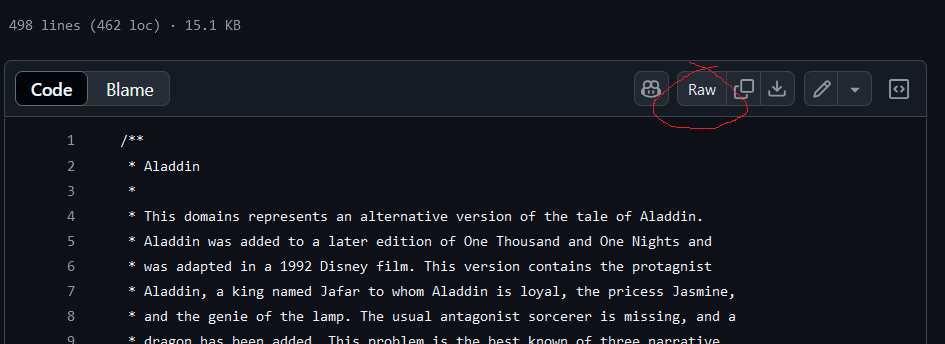

In [6]:
# !wget https://raw.githubusercontent.com/sgware/sabre-benchmarks/refs/heads/main/problems/raiders.txt

## Run Sabre
Here are all the flags that you can use when running Sabre.

```
The Sabre Narrative Planner v0.7 by Stephen G. Ware
-help        print this message and halt
-v           verbose output gives details of the search and results
-p PATH      problem file to parse
-g NUMBER    utility a solution much reach (default round up or +1)
-m OPTION    heuristic search method; options include:
   bf        A* best-first (default)
   ef        explanation-first: explain actions before achieving the goal
   gf        goal-first: achieve the goal before explaining actions
-c OPTION    how plan cost is measured; options include:
   0         always zero
   n         number of actions in the plan
   t         number of actions before the plan and in the plan (default)
-cw NUMBER   a weight to multiply the cost by
-h OPTION    how distance to the goal is estimated; options include:
   0         always zero
   r         prevent some searches with impossible goals
   hmax      estimate cost when a conjunction costs the max of its arguments
   h+        estimate cost when a conjunction costs the sum of its arguments
   rp        build a relaxed plan to approximate the solution (default)
-hw NUMBER   a weight to multiply the heuristic by
-ep {y|n}    once one explanation has been found for an action, do not search for more (default y)
-vl NUMBER   max nodes the search can visit; 0 for unlimited (default 0)
-gl NUMBER   max nodes the search can generate; 0 for unlimited (default 0)
-tl NUMBER   max milliseconds the search can run; 0 for unlimited (default 0)
-atl NUMBER  max actions in a plan; -1 for unlimited (default -1)
-ctl NUMBER  max actions in a character's explanation for an action; -1 for unlimited (default -1)
-el NUMBER   max depth to explore theory of mind; -1 for unlimited (default -1)
```



In [19]:
# filename = "raiders.txt" #TODO: change this filename to whatever Sabre problem file you're running
# run('java -jar sabre/lib/sabre.jar -v -p '+ filename+' -h h+ -el 1')

# Fill in and run your own problem

# Part 1: Implemented all the actions

In [ ]:
problem = """
/**
* Action Castle
*
* This domain is based off of the Parsely Action Castle game.
* http://memento-mori.com/pdf/parsely-preview-n-play-edition
*/

/* entity types */
type location;
type character : location;
type item;
type sceneItem : item;
type npc : character;
type cond;
type charType;
type emotion;

/* specific entities in the story */
entity Cottage : location;
entity GardenPath : location;
entity FishingPond : location;
entity WindingPath : location;
entity TopOfTree  : location;
entity Drawbridge : location;
entity Courtyard : location;
entity TowerStairs : location;
entity Tower : location;
entity DungeonStairs : location;
entity Dungeon : location;
entity FeastingHall : location;
entity ThroneRoom : location;
entity FishingPole : item;
entity Crown : item;
entity Branch : item;
entity Candle : item;
entity Lamp : item;
entity Fish : item;
entity Key : item;
entity Rose : item;
entity Sword : item;
entity Pond : sceneItem;
entity Throne : sceneItem;
entity Door : sceneItem;
entity Player : character;
entity Troll : npc;
entity Guard : npc;
entity Princess : npc;
entity Ghost : npc;
entity Lit : cond;
entity HasFish : cond;
entity HasRose : cond;
entity Locked : cond;
entity Human : charType;
entity GhostType : charType;
entity TrollType : charType;
entity Sad : emotion;
entity Happy : emotion;
entity Suspicious : emotion;

/* properties of entities */
property path(from : location, to : location) : boolean;
property inv(item : item) : character;
property location(character : character) : location;
property location(item : item) : location;
property condition(item : item) : cond;
property fragile(item : item) : boolean;
property royal (character : character) : boolean;
property gettable(item : item) : boolean;
property sittable(item : item) : boolean;
property hungry(character : character) : boolean;
property incapacitated(character : character) : boolean; /* banished for ghost, dead/unconscious for humans & trolls */
property characterType(character : character) : charType;
property married(character: character) : boolean;
property emotion(character : character) : emotion;
property lightable(item : item) : boolean;
property crowned(character : character) : boolean;
property locked(sceneItem : sceneItem) : boolean;
property weapon(item : item) : boolean;

/* starting state conditions */
path(Cottage,GardenPath);
path(GardenPath, FishingPond);
path(GardenPath, WindingPath);
path(WindingPath, TopOfTree);
path(WindingPath, Drawbridge);
path(Courtyard, TowerStairs);
path(Courtyard, DungeonStairs);
path(Courtyard, FeastingHall);
path(DungeonStairs, Dungeon);
path(FeastingHall, ThroneRoom);
location(FishingPole) = Cottage;
location(Candle) = FeastingHall;
location(Pond) = FishingPond;
location(Throne) = ThroneRoom;
location(Door) = TowerStairs;
location(Player) = Cottage;
location(Princess) = Tower;
location(Guard) = Courtyard;
location(Troll) = Drawbridge;
location(Ghost) = Dungeon;
location(Rose) = GardenPath;
location(Branch) = TopOfTree;
inv(Lamp) = Player;
inv(Crown) = Ghost;
inv(Key) = Guard;
condition(Door) = Locked;
condition(Pond) = HasFish;
forall(npc : npc)
	!incapacitated(npc);
characterType(Player) = Human;
characterType(Guard) = Human;
characterType(Princess) = Human;
characterType(Troll) = TrollType;
characterType(Ghost) = GhostType;
emotion(Guard) = Suspicious;
emotion(Princess) = Sad;
emotion(Player) = Happy;
hungry(Troll);
locked(Door);
gettable(FishingPole);
gettable(Branch);
gettable(Candle);
gettable(Rose);
royal(Princess);
lightable(Lamp);
lightable(Candle);
weapon(Sword);
weapon(Branch);

/* actions */
action unlock(character : character) {
  /* Character unlocks the Door
   *
   * the character is in the same room as the Door
   * the character has the Key in their inventory
   * the character is not incapacitated
   * the Door is locked
   * effect: the door is unlocked & there is a path from the tower stairs to the tower
   */

  precondition:
    location(character) == location(Door) &
    inv(Key) == character &
    !incapacitated(character) &
    locked(Door);

  effect:
    !locked(Door) &
    path(TowerStairs, Tower);
};

action light(character : character, item : item) {
  /* Character lights an item
   *
   * the character needs the item in their inventory
   * the item needs to be lightable
   * the item needs to not be lit
   * the character needs to not be incapacitated
   * effect: the item is lit
   */

  precondition:
    inv(item) == character &
    lightable(item) &
    condition(item) != Lit &
    !incapacitated(character);

  effect:
    condition(item) = Lit;
};

action read(character : character, npc : npc) {
  /* Player reads the Candle runes to the Ghost.
   *
   * NPC and character are in the same location
   * they are not the same person
   * neither are incapacitated
   * they are both happy
   * they are both unmarried
   * effect: ghost is incapacitated &
   * the crown is not in anyone's inventory &
   * the Crown's location is with the Ghost &
   * the Crown is gettable
   */

  precondition:
    location(character) == location(npc) &
    character != npc &
    !incapacitated(character) &
    !incapacitated(npc) &
    emotion(character) == Happy &
    emotion(npc) == Happy &
    !married(character) &
    !married(npc);

  effect:
    incapacitated(npc) &
    inv(Crown) = ? &
    location(Crown) = npc &
    gettable(Crown);
};

action propose(character : character, npc : npc) {
  /* Character proposes to NPC.
   *
   * NPC and character are in the same location
   * they are not the same person
   * neither are incapacitated
   * they are both happy
   * they are both unmarried
   * effect: they become married & the character becomes royal if npc is royal
   */

  precondition:
    location(character) == location(npc) &
    character != npc &
    !incapacitated(character) &
    !incapacitated(npc) &
    emotion(character) == Happy &
    emotion(npc) == Happy &
    !married(character) &
    !married(npc);

  effect:
    married(character) &
    married(npc) &
    if(royal(npc))
      royal(character);
};

action give(character : character, npc : npc, item : item) {
  /* Character gives NPC an item.
   *
   * the item needs to be in their inventory
   * the NPC and character need to be in the same room
   * neither can be incapacitated
   * they can't be the same person
   * effect: the npc is happy & the item is in the npc's inventory &
   * if the npc is the Troll,
   *     the Troll's location is null & the path from the drawbridge to the courtyard opens
   */

  precondition:
    inv(item) == character &
    location(character) == location(npc) &
    character != npc &
    !incapacitated(character) &
    !incapacitated(npc);

  effect:
    inv(item) = npc &
    emotion(npc) = Happy &
    if(npc == Troll) (
      location(Troll) = ? &
      path(Drawbridge, Courtyard)
    );
};

action wear(character : character) {
  /* Character wears the crown.
   *
   * character is royal
   * character is not incapacitated
   * character has the Crown
   * effect: the character is crowned
   */

  precondition:
    royal(character) &
    !incapacitated(character) &
    inv(Crown) == character;

  effect:
    crowned(character);
};

action sit(character : character, location : location){
  /* Character sits on the throne.
   *
   * character is royal
   * character is not incapacitated
   * character and Throne are in the same location
   * effect: the character is crowned
   */

  precondition:
    royal(character) &
    !incapacitated(character) &
    location(character) == location &
    location(Throne) == location;

  effect:
    crowned(character);
};

action walk(from : location, to : location) {
  /* Player walks from one location to another.
   *
   * character is not incapacitated
   * character is at the "from" location
   * the two locations are not the same
   * there is a path between the two locations
   * effect: player is at location "to"
   */

  precondition:
    !incapacitated(Player) &
    location(Player) == from &
    from != to &
    path(from, to);

  effect:
    location(Player) = to;
};

action hit(character : character, npc : npc, item : item) {
  /* Character hits NPC with item.
   *
   * character and npc need to both be at the same location
   * both need to not be incapacitated
   * npc needs to be human
   * character needs to have the item
   * the item needs to be a weapon
   * effect: npc is incapacitated &
   * if the npc is the Guard:
   *     nobody has the Key and Sword in their inventory
   *     the location of the Key and Sword are at the current location
   *     the Key and Sword are gettable
   */

  precondition:
    location(character) == location(npc) &
    !incapacitated(character) &
    !incapacitated(npc) &
    character != npc &
    characterType(npc) == Human &
    inv(item) == character &
    weapon(item);

  effect:
    incapacitated(npc) &
    if(npc == Guard) (
      inv(Key) = ? &
      inv(Sword) = ? &
      location(Key) = location(character) &
      location(Sword) = location(character) &
      gettable(Key) &
      gettable(Sword)
    );
};

action fish(character : character){
  /* Character goes fishing.
   *
   * character needs to be at FishingPond
   * Pond needs "HasFish"
   * character needs a fishing pole
   * effect: Fish in character's inventory & Pond is not "HasFish"
   */

  precondition:
    location(character) == FishingPond &
    condition(Pond) == HasFish &
    inv(FishingPole) == character;

  effect:
    inv(Fish) = character &
    condition(Pond) = ?;
};

action get(character : character, item : item){
  /* Character picks up an item.
   *
   * character needs to be in the same location as the item
   * item needs to be gettable
   * item needs to not be in inventory
   * effect: item in inventory
   */

  precondition:
    location(character) == location(item) &
    gettable(item) &
    inv(item) != character &
    !incapacitated(character);

  effect:
    inv(item) = character;
};

/* triggers */
trigger path_to(from : location, to : location) {
	precondition:
		path(from, to) &
		!path(to, from);
	effect:
		path(to, from);
};

/* utility */
/* utility(): */

"""

# Part 2

## Utility 1:

if(royal(Player)) 1 else 0

In [8]:
problem = """
/**
* Action Castle
*
* This domain is based off of the Parsely Action Castle game.
* http://memento-mori.com/pdf/parsely-preview-n-play-edition
*/

/* entity types */
type location;
type character : location;
type item;
type sceneItem : item;
type npc : character;
type cond;
type charType;
type emotion;

/* specific entities in the story */
entity Cottage : location;
entity GardenPath : location;
entity FishingPond : location;
entity WindingPath : location;
entity TopOfTree  : location;
entity Drawbridge : location;
entity Courtyard : location;
entity TowerStairs : location;
entity Tower : location;
entity DungeonStairs : location;
entity Dungeon : location;
entity FeastingHall : location;
entity ThroneRoom : location;
entity FishingPole : item;
entity Crown : item;
entity Branch : item;
entity Candle : item;
entity Lamp : item;
entity Fish : item;
entity Key : item;
entity Rose : item;
entity Sword : item;
entity Pond : sceneItem;
entity Throne : sceneItem;
entity Door : sceneItem;
entity Player : character;
entity Troll : npc;
entity Guard : npc;
entity Princess : npc;
entity Ghost : npc;
entity Lit : cond;
entity HasFish : cond;
entity HasRose : cond;
entity Locked : cond;
entity Human : charType;
entity GhostType : charType;
entity TrollType : charType;
entity Sad : emotion;
entity Happy : emotion;
entity Suspicious : emotion;

/* properties of entities */
property path(from : location, to : location) : boolean;
property inv(item : item) : character;
property location(character : character) : location;
property location(item : item) : location;
property condition(item : item) : cond;
property fragile(item : item) : boolean;
property royal (character : character) : boolean;
property gettable(item : item) : boolean;
property sittable(item : item) : boolean;
property hungry(character : character) : boolean;
property incapacitated(character : character) : boolean; /* banished for ghost, dead/unconscious for humans & trolls */
property characterType(character : character) : charType;
property married(character: character) : boolean;
property emotion(character : character) : emotion;
property lightable(item : item) : boolean;
property crowned(character : character) : boolean;
property locked(sceneItem : sceneItem) : boolean;
property weapon(item : item) : boolean;

/* starting state conditions */
path(Cottage,GardenPath);
path(GardenPath, FishingPond);
path(GardenPath, WindingPath);
path(WindingPath, TopOfTree);
path(WindingPath, Drawbridge);
path(Courtyard, TowerStairs);
path(Courtyard, DungeonStairs);
path(Courtyard, FeastingHall);
path(DungeonStairs, Dungeon);
path(FeastingHall, ThroneRoom);
location(FishingPole) = Cottage;
location(Candle) = FeastingHall;
location(Pond) = FishingPond;
location(Throne) = ThroneRoom;
location(Door) = TowerStairs;
location(Player) = Cottage;
location(Princess) = Tower;
location(Guard) = Courtyard;
location(Troll) = Drawbridge;
location(Ghost) = Dungeon;
location(Rose) = GardenPath;
location(Branch) = TopOfTree;
inv(Lamp) = Player;
inv(Crown) = Ghost;
inv(Key) = Guard;
condition(Door) = Locked;
condition(Pond) = HasFish;
forall(npc : npc)
	!incapacitated(npc);
characterType(Player) = Human;
characterType(Guard) = Human;
characterType(Princess) = Human;
characterType(Troll) = TrollType;
characterType(Ghost) = GhostType;
emotion(Guard) = Suspicious;
emotion(Princess) = Sad;
emotion(Player) = Happy;
hungry(Troll);
locked(Door);
gettable(FishingPole);
gettable(Branch);
gettable(Candle);
gettable(Rose);
royal(Princess);
lightable(Lamp);
lightable(Candle);
weapon(Sword);
weapon(Branch);

/* actions */
action unlock(character : character) {
  /* Character unlocks the Door
   *
   * the character is in the same room as the Door
   * the character has the Key in their inventory
   * the character is not incapacitated
   * the Door is locked
   * effect: the door is unlocked & there is a path from the tower stairs to the tower
   */

  precondition:
    location(character) == location(Door) &
    inv(Key) == character &
    !incapacitated(character) &
    locked(Door);

  effect:
    !locked(Door) &
    path(TowerStairs, Tower);
};

action light(character : character, item : item) {
  /* Character lights an item
   *
   * the character needs the item in their inventory
   * the item needs to be lightable
   * the item needs to not be lit
   * the character needs to not be incapacitated
   * effect: the item is lit
   */

  precondition:
    inv(item) == character &
    lightable(item) &
    condition(item) != Lit &
    !incapacitated(character);

  effect:
    condition(item) = Lit;
};

action read(character : character, npc : npc) {
  /* Player reads the Candle runes to the Ghost.
   *
   * NPC and character are in the same location
   * they are not the same person
   * neither are incapacitated
   * they are both happy
   * they are both unmarried
   * effect: ghost is incapacitated &
   * the crown is not in anyone's inventory &
   * the Crown's location is with the Ghost &
   * the Crown is gettable
   */

  precondition:
    location(character) == location(npc) &
    character != npc &
    !incapacitated(character) &
    !incapacitated(npc) &
    emotion(character) == Happy &
    emotion(npc) == Happy &
    !married(character) &
    !married(npc);

  effect:
    incapacitated(npc) &
    inv(Crown) = ? &
    location(Crown) = npc &
    gettable(Crown);
};

action propose(character : character, npc : npc) {
  /* Character proposes to NPC.
   *
   * NPC and character are in the same location
   * they are not the same person
   * neither are incapacitated
   * they are both happy
   * they are both unmarried
   * effect: they become married & the character becomes royal if npc is royal
   */

  precondition:
    location(character) == location(npc) &
    character != npc &
    !incapacitated(character) &
    !incapacitated(npc) &
    emotion(character) == Happy &
    emotion(npc) == Happy &
    !married(character) &
    !married(npc);

  effect:
    married(character) &
    married(npc) &
    if(royal(npc))
      royal(character);
};

action give(character : character, npc : npc, item : item) {
  /* Character gives NPC an item.
   *
   * the item needs to be in their inventory
   * the NPC and character need to be in the same room
   * neither can be incapacitated
   * they can't be the same person
   * effect: the npc is happy & the item is in the npc's inventory &
   * if the npc is the Troll,
   *     the Troll's location is null & the path from the drawbridge to the courtyard opens
   */

  precondition:
    inv(item) == character &
    location(character) == location(npc) &
    character != npc &
    !incapacitated(character) &
    !incapacitated(npc);

  effect:
    inv(item) = npc &
    emotion(npc) = Happy &
    if(npc == Troll) (
      location(Troll) = ? &
      path(Drawbridge, Courtyard)
    );
};

action wear(character : character) {
  /* Character wears the crown.
   *
   * character is royal
   * character is not incapacitated
   * character has the Crown
   * effect: the character is crowned
   */

  precondition:
    royal(character) &
    !incapacitated(character) &
    inv(Crown) == character;

  effect:
    crowned(character);
};

action sit(character : character, location : location){
  /* Character sits on the throne.
   *
   * character is royal
   * character is not incapacitated
   * character and Throne are in the same location
   * effect: the character is crowned
   */

  precondition:
    royal(character) &
    !incapacitated(character) &
    location(character) == location &
    location(Throne) == location;

  effect:
    crowned(character);
};

action walk(from : location, to : location) {
  /* Player walks from one location to another.
   *
   * character is not incapacitated
   * character is at the "from" location
   * the two locations are not the same
   * there is a path between the two locations
   * effect: player is at location "to"
   */

  precondition:
    !incapacitated(Player) &
    location(Player) == from &
    from != to &
    path(from, to);

  effect:
    location(Player) = to;
};

action hit(character : character, npc : npc, item : item) {
  /* Character hits NPC with item.
   *
   * character and npc need to both be at the same location
   * both need to not be incapacitated
   * npc needs to be human
   * character needs to have the item
   * the item needs to be a weapon
   * effect: npc is incapacitated &
   * if the npc is the Guard:
   *     nobody has the Key and Sword in their inventory
   *     the location of the Key and Sword are at the current location
   *     the Key and Sword are gettable
   */

  precondition:
    location(character) == location(npc) &
    !incapacitated(character) &
    !incapacitated(npc) &
    character != npc &
    characterType(npc) == Human &
    inv(item) == character &
    weapon(item);

  effect:
    incapacitated(npc) &
    if(npc == Guard) (
      inv(Key) = ? &
      inv(Sword) = ? &
      location(Key) = location(character) &
      location(Sword) = location(character) &
      gettable(Key) &
      gettable(Sword)
    );
};

action fish(character : character){
  /* Character goes fishing.
   *
   * character needs to be at FishingPond
   * Pond needs "HasFish"
   * character needs a fishing pole
   * effect: Fish in character's inventory & Pond is not "HasFish"
   */

  precondition:
    location(character) == FishingPond &
    condition(Pond) == HasFish &
    inv(FishingPole) == character;

  effect:
    inv(Fish) = character &
    condition(Pond) = ?;
};

action get(character : character, item : item){
  /* Character picks up an item.
   *
   * character needs to be in the same location as the item
   * item needs to be gettable
   * item needs to not be in inventory
   * effect: item in inventory
   */

  precondition:
    location(character) == location(item) &
    gettable(item) &
    inv(item) != character &
    !incapacitated(character);

  effect:
    inv(item) = character;
};

/* triggers */
trigger path_to(from : location, to : location) {
	precondition:
		path(from, to) &
		!path(to, from);
	effect:
		path(to, from);
};

/* utility */
utility():
 if(royal(Player)) 1 else 0;

"""

In [9]:
outfile = open("action-castle.txt",'w')
outfile.write(problem)
outfile.close()
run('java -jar sabre/lib/sabre.jar -v -p action-castle.txt -h h+ -el 1')

>> java -jar sabre/lib/sabre.jar -v -p action-castle.txt -h h+ -el 1
The Sabre Narrative Planner v0.7 by Stephen G. Ware
Problem: action-castle
  characters: 5
  entities:   40
  fluents:    18
  actions:    11
  triggers:   1
Simplifying problem "action-castle": 463/463 fluents; 1253/1253 events; 6/6 utilities
Compiled Problem: action-castle
  characters: 5
  entities:   40
  fluents:    59
  actions:    118
  triggers:   4
Heuristic Progression Search:
  problem:               action-castle
  starting utility:      0
  goal utility:          1
  method:                best-first
  cost:                  temporal
  heuristic:             sum graph
  explanation pruning:   true
  search limit:          unlimited
  space limit:           unlimited
  time limit:            unlimited
  author temporal limit: unlimited
  character limit:       unlimited
  epistemic limit:       1
Heuristic progression search for "action-castle": 338176 visited; 1576386 generated; 954652 in queue
Result: Su

## Utility 2:
if(inv(Crown) == Player) 1 else 0

In [10]:
problem = """
/**
* Action Castle
*
* This domain is based off of the Parsely Action Castle game.
* http://memento-mori.com/pdf/parsely-preview-n-play-edition
*/

/* entity types */
type location;
type character : location;
type item;
type sceneItem : item;
type npc : character;
type cond;
type charType;
type emotion;

/* specific entities in the story */
entity Cottage : location;
entity GardenPath : location;
entity FishingPond : location;
entity WindingPath : location;
entity TopOfTree  : location;
entity Drawbridge : location;
entity Courtyard : location;
entity TowerStairs : location;
entity Tower : location;
entity DungeonStairs : location;
entity Dungeon : location;
entity FeastingHall : location;
entity ThroneRoom : location;
entity FishingPole : item;
entity Crown : item;
entity Branch : item;
entity Candle : item;
entity Lamp : item;
entity Fish : item;
entity Key : item;
entity Rose : item;
entity Sword : item;
entity Pond : sceneItem;
entity Throne : sceneItem;
entity Door : sceneItem;
entity Player : character;
entity Troll : npc;
entity Guard : npc;
entity Princess : npc;
entity Ghost : npc;
entity Lit : cond;
entity HasFish : cond;
entity HasRose : cond;
entity Locked : cond;
entity Human : charType;
entity GhostType : charType;
entity TrollType : charType;
entity Sad : emotion;
entity Happy : emotion;
entity Suspicious : emotion;

/* properties of entities */
property path(from : location, to : location) : boolean;
property inv(item : item) : character;
property location(character : character) : location;
property location(item : item) : location;
property condition(item : item) : cond;
property fragile(item : item) : boolean;
property royal (character : character) : boolean;
property gettable(item : item) : boolean;
property sittable(item : item) : boolean;
property hungry(character : character) : boolean;
property incapacitated(character : character) : boolean; /* banished for ghost, dead/unconscious for humans & trolls */
property characterType(character : character) : charType;
property married(character: character) : boolean;
property emotion(character : character) : emotion;
property lightable(item : item) : boolean;
property crowned(character : character) : boolean;
property locked(sceneItem : sceneItem) : boolean;
property weapon(item : item) : boolean;

/* starting state conditions */
path(Cottage,GardenPath);
path(GardenPath, FishingPond);
path(GardenPath, WindingPath);
path(WindingPath, TopOfTree);
path(WindingPath, Drawbridge);
path(Courtyard, TowerStairs);
path(Courtyard, DungeonStairs);
path(Courtyard, FeastingHall);
path(DungeonStairs, Dungeon);
path(FeastingHall, ThroneRoom);
location(FishingPole) = Cottage;
location(Candle) = FeastingHall;
location(Pond) = FishingPond;
location(Throne) = ThroneRoom;
location(Door) = TowerStairs;
location(Player) = Cottage;
location(Princess) = Tower;
location(Guard) = Courtyard;
location(Troll) = Drawbridge;
location(Ghost) = Dungeon;
location(Rose) = GardenPath;
location(Branch) = TopOfTree;
inv(Lamp) = Player;
inv(Crown) = Ghost;
inv(Key) = Guard;
condition(Door) = Locked;
condition(Pond) = HasFish;
forall(npc : npc)
	!incapacitated(npc);
characterType(Player) = Human;
characterType(Guard) = Human;
characterType(Princess) = Human;
characterType(Troll) = TrollType;
characterType(Ghost) = GhostType;
emotion(Guard) = Suspicious;
emotion(Princess) = Sad;
emotion(Player) = Happy;
hungry(Troll);
locked(Door);
gettable(FishingPole);
gettable(Branch);
gettable(Candle);
gettable(Rose);
royal(Princess);
lightable(Lamp);
lightable(Candle);
weapon(Sword);
weapon(Branch);

/* actions */
action unlock(character : character) {
  /* Character unlocks the Door
   *
   * the character is in the same room as the Door
   * the character has the Key in their inventory
   * the character is not incapacitated
   * the Door is locked
   * effect: the door is unlocked & there is a path from the tower stairs to the tower
   */

  precondition:
    location(character) == location(Door) &
    inv(Key) == character &
    !incapacitated(character) &
    locked(Door);

  effect:
    !locked(Door) &
    path(TowerStairs, Tower);
};

action light(character : character, item : item) {
  /* Character lights an item
   *
   * the character needs the item in their inventory
   * the item needs to be lightable
   * the item needs to not be lit
   * the character needs to not be incapacitated
   * effect: the item is lit
   */

  precondition:
    inv(item) == character &
    lightable(item) &
    condition(item) != Lit &
    !incapacitated(character);

  effect:
    condition(item) = Lit;
};

action read() {
  /* Player reads the Candle runes to the Ghost.
   * Removed character and npc parameters to match expected solution
   */
  precondition:
    location(Player) == location(Ghost) &
    !incapacitated(Player) &
    !incapacitated(Ghost) &
    emotion(Player) == Happy &
    emotion(Ghost) == Happy &
    !married(Player) &
    !married(Ghost) &
    inv(Candle) == Ghost;

  effect:
    incapacitated(Ghost) &
    inv(Crown) = ? &
    location(Crown) = location(Ghost) &
    gettable(Crown);
};

action propose(character : character, npc : npc) {
  /* Character proposes to NPC.
   *
   * NPC and character are in the same location
   * they are not the same person
   * neither are incapacitated
   * they are both happy
   * they are both unmarried
   * effect: they become married & the character becomes royal if npc is royal
   */

  precondition:
    location(character) == location(npc) &
    character != npc &
    !incapacitated(character) &
    !incapacitated(npc) &
    emotion(character) == Happy &
    emotion(npc) == Happy &
    !married(character) &
    !married(npc);

  effect:
    married(character) &
    married(npc) &
    if(royal(npc))
      royal(character);
};

action give(character : character, npc : npc, item : item) {
  /* Character gives NPC an item.
   *
   * the item needs to be in their inventory
   * the NPC and character need to be in the same room
   * neither can be incapacitated
   * they can't be the same person
   * effect: the npc is happy & the item is in the npc's inventory &
   * if the npc is the Troll,
   *     the Troll's location is null & the path from the drawbridge to the courtyard opens
   */

  precondition:
    inv(item) == character &
    location(character) == location(npc) &
    character != npc &
    !incapacitated(character) &
    !incapacitated(npc);

  effect:
    inv(item) = npc &
    emotion(npc) = Happy &
    if(npc == Troll) (
      location(Troll) = ? &
      path(Drawbridge, Courtyard)
    );
};

action wear(character : character) {
  /* Character wears the crown.
   *
   * character is royal
   * character is not incapacitated
   * character has the Crown
   * effect: the character is crowned
   */

  precondition:
    royal(character) &
    !incapacitated(character) &
    inv(Crown) == character;

  effect:
    crowned(character);
};

action sit(character : character, location : location){
  /* Character sits on the throne.
   *
   * character is royal
   * character is not incapacitated
   * character and Throne are in the same location
   * effect: the character is crowned
   */

  precondition:
    royal(character) &
    !incapacitated(character) &
    location(character) == location &
    location(Throne) == location;

  effect:
    crowned(character);
};

action walk(from : location, to : location) {
  /* Player walks from one location to another.
   *
   * character is not incapacitated
   * character is at the "from" location
   * the two locations are not the same
   * there is a path between the two locations
   * effect: player is at location "to"
   */

  precondition:
    !incapacitated(Player) &
    location(Player) == from &
    from != to &
    path(from, to);

  effect:
    location(Player) = to;
};

action hit(character : character, npc : npc, item : item) {
  /* Character hits NPC with item.
   *
   * character and npc need to both be at the same location
   * both need to not be incapacitated
   * npc needs to be human
   * character needs to have the item
   * the item needs to be a weapon
   * effect: npc is incapacitated &
   * if the npc is the Guard:
   *     nobody has the Key and Sword in their inventory
   *     the location of the Key and Sword are at the current location
   *     the Key and Sword are gettable
   */

  precondition:
    location(character) == location(npc) &
    !incapacitated(character) &
    !incapacitated(npc) &
    character != npc &
    characterType(npc) == Human &
    inv(item) == character &
    weapon(item);

  effect:
    incapacitated(npc) &
    if(npc == Guard) (
      inv(Key) = ? &
      inv(Sword) = ? &
      location(Key) = location(character) &
      location(Sword) = location(character) &
      gettable(Key) &
      gettable(Sword)
    );
};

action fish(character : character){
  /* Character goes fishing.
   *
   * character needs to be at FishingPond
   * Pond needs "HasFish"
   * character needs a fishing pole
   * effect: Fish in character's inventory & Pond is not "HasFish"
   */

  precondition:
    location(character) == FishingPond &
    condition(Pond) == HasFish &
    inv(FishingPole) == character;

  effect:
    inv(Fish) = character &
    condition(Pond) = ?;
};



action get(character : character, item : item){
  /* Character picks up an item.
   * Removed location parameter since it can be derived
   */
  precondition:
    location(character) == location(item) &
    gettable(item) &
    inv(item) == ? &
    !incapacitated(character);

  effect:
    inv(item) = character;
};

/* triggers */
trigger path_to(from : location, to : location) {
	precondition:
		path(from, to) &
		!path(to, from);
	effect:
		path(to, from);
};

/* utility */
utility():
  if(inv(Crown) == Player) 1 else 0;


"""

In [11]:
outfile = open("action-castle.txt", 'w')
outfile.write(problem)
outfile.close()
run('java -jar sabre/lib/sabre.jar -v -p action-castle.txt -h h+ -el 1')


>> java -jar sabre/lib/sabre.jar -v -p action-castle.txt -h h+ -el 1
The Sabre Narrative Planner v0.7 by Stephen G. Ware
Problem: action-castle
  characters: 5
  entities:   40
  fluents:    18
  actions:    11
  triggers:   1
Simplifying problem "action-castle": 463/463 fluents; 1238/1238 events; 6/6 utilities
Compiled Problem: action-castle
  characters: 5
  entities:   40
  fluents:    59
  actions:    116
  triggers:   4
Heuristic Progression Search:
  problem:               action-castle
  starting utility:      0
  goal utility:          1
  method:                best-first
  cost:                  temporal
  heuristic:             sum graph
  explanation pruning:   true
  search limit:          unlimited
  space limit:           unlimited
  time limit:            unlimited
  author temporal limit: unlimited
  character limit:       unlimited
  epistemic limit:       1
Result: Success!
  solution:         true
  utility achieved: 1
  nodes visited:    207
  nodes generated:  416

## Utility for every character & Changed the walk() action to allow all characters to walk around

In [17]:
problem = """
/**
* Action Castle
*
* This domain is based off of the Parsely Action Castle game.
* http://memento-mori.com/pdf/parsely-preview-n-play-edition
*/

/* entity types */
type location;
type character : location;
type item;
type sceneItem : item;
type npc : character;
type cond;
type charType;
type emotion;


/* specific entities in the story */
entity Cottage : location;
entity GardenPath : location;
entity FishingPond : location;
entity WindingPath : location;
entity TopOfTree  : location;
entity Drawbridge : location;
entity Courtyard : location;
entity TowerStairs : location;
entity Tower : location;
entity DungeonStairs : location;
entity Dungeon : location;
entity FeastingHall : location;
entity ThroneRoom : location;
entity FishingPole : item;
entity Crown : item;
entity Branch : item;
entity Candle : item;
entity Lamp : item;
entity Fish : item;
entity Key : item;
entity Rose : item;
entity Sword : item;
entity Pond : sceneItem;
entity Throne : sceneItem;
entity Door : sceneItem;
entity Player : character;
entity Troll : npc;
entity Guard : npc;
entity Princess : npc;
entity Ghost : npc;
entity Lit : cond;
entity HasFish : cond;
entity HasRose : cond;
entity Locked : cond;
entity Human : charType;
entity GhostType : charType;
entity TrollType : charType;
entity Sad : emotion;
entity Happy : emotion;
entity Suspicious : emotion;


/* properties of entities */
property path(from : location, to : location) : boolean;
property inv(item : item) : character;
property location(character : character) : location;
property location(item : item) : location;
property condition(item : item) : cond;
property fragile(item : item) : boolean;
property royal (character : character) : boolean;
property gettable(item : item) : boolean;
property sittable(item : item) : boolean;
property hungry(character : character) : boolean;
property incapacitated(character : character) : boolean;
property characterType(character : character) : charType;
property married(character: character) : boolean;
property emotion(character : character) : emotion;
property lightable(item : item) : boolean;
property crowned(character : character) : boolean;
property locked(sceneItem : sceneItem) : boolean;
property weapon(item : item) : boolean;


/* starting state conditions */
path(Cottage,GardenPath);
path(GardenPath, FishingPond);
path(GardenPath, WindingPath);
path(WindingPath, TopOfTree);
path(WindingPath, Drawbridge);
path(Courtyard, TowerStairs);
path(Courtyard, DungeonStairs);
path(Courtyard, FeastingHall);
path(DungeonStairs, Dungeon);
path(FeastingHall, ThroneRoom);
location(FishingPole) = Cottage;
location(Candle) = FeastingHall;
location(Pond) = FishingPond;
location(Throne) = ThroneRoom;
location(Door) = TowerStairs;
location(Player) = Cottage;
location(Princess) = Tower;
location(Guard) = Courtyard;
location(Troll) = Drawbridge;
location(Ghost) = Dungeon;
location(Rose) = GardenPath;
location(Branch) = TopOfTree;
inv(Lamp) = Player;
inv(Crown) = Ghost;
inv(Key) = Guard;
condition(Door) = Locked;
condition(Pond) = HasFish;
forall(npc : npc)
	!incapacitated(npc);
characterType(Player) = Human;
characterType(Guard) = Human;
characterType(Princess) = Human;
characterType(Troll) = TrollType;
characterType(Ghost) = GhostType;
emotion(Guard) = Suspicious;
emotion(Princess) = Sad;
emotion(Player) = Happy;
hungry(Troll);
locked(Door);
gettable(FishingPole);
gettable(Branch);
gettable(Candle);
gettable(Rose);
royal(Princess);
lightable(Lamp);
lightable(Candle);
weapon(Sword);
weapon(Branch);


/* actions */
action unlock(character : character) {
  precondition:
    location(character) == TowerStairs &
    inv(Key) == character &
    !incapacitated(character) &
    locked(Door);

  effect:
    !locked(Door) &
    path(TowerStairs, Tower);
};

action light(character : character, item : item) {
  precondition:
    inv(item) == character &
    lightable(item) &
    !condition(item) == Lit &
    !incapacitated(character);

  effect:
    condition(item) = Lit;
};

action read() {
  precondition:
    location(Player) == location(Ghost) &
    Player != Ghost &
    !incapacitated(Player) &
    !incapacitated(Ghost) &
    emotion(Player) == Happy &
    emotion(Ghost) == Happy &
    !married(Player) &
    !married(Ghost);

  effect:
    incapacitated(Ghost) &
    inv(Crown) =? &
    location(Crown) == location(Ghost) &
    gettable(Crown);
};

action propose(character : character, npc : npc) {
  precondition:
    location(character) == location(npc) &
    character != npc &
    !incapacitated(character) &
    !incapacitated(npc) &
    emotion(character) == Happy &
    emotion(npc) == Happy &
    !married(character) &
    !married(npc);

  effect:
    married(character) &
    married(npc) &
    if(royal(npc))
      royal(character);
};

action give(character : character, npc : npc, item : item) {
  precondition:
    inv(item) == character &
    location(character) == location(npc) &
    !incapacitated(character) &
    !incapacitated(npc) &
    character != npc;

  effect:
    emotion(npc) = Happy &
    inv(item) = npc &
    if(npc == Troll)
      location(Troll) =? &
      path(Drawbridge, Courtyard);
};

action wear(character : character) {
  precondition:
    royal(character) &
    !incapacitated(character) &
    inv(Crown) == character;

  effect:
    crowned(character);
};

action sit(character : character, location : location){
  precondition:
    royal(character) &
    !incapacitated(character) &
    location(character) == location(Throne);

  effect:
    crowned(character);
};

/* Changed the walk() action to allow all characters to walk around  by adding the character paramater*/

action walk(character : character, from : location, to : location) {
  /* Character walks from one location to another.
   * Character is not incapacitated
   * Character is at the "from" location
   * the two locations are not the same
   * there is a path between the two locations
   * effect: Character is at location "to"
   */

   precondition:
    !incapacitated(character) &
    location(character) == from &
    from != to &
    path(from, to);

  effect:
    location(character) = to;
};

action hit(character : character, npc : npc, item : item, location : location) {
  precondition:
    location(character) == location &
    location(npc) == location &
    !incapacitated(character) &
    !incapacitated(npc) &
    characterType(npc) == Human &
    inv(item) == character &
    weapon(item);

  effect:
    incapacitated(npc) &
    if(npc == Guard)
      inv(Key) =? &
      inv(Sword) =? &
      location(Key) = location &
      location(Sword) = location &
      gettable(Key) &
      gettable(Sword);
};

action fish(character : character){
  precondition:
    location(character) == FishingPond &
    condition(Pond) == HasFish &
    inv(FishingPole) == character;

  effect:
    inv(Fish) = character &
    condition(Pond) =?;
};

action get(character : character, item : item, location : location){
  precondition:
    location(character) == location(item) &
    gettable(item) &
    inv(item) ==?;

  effect:
    inv(item) = character;
};


/* triggers */
trigger path_to(from : location, to : location) {
	precondition:
		path(from, to) &
		!path(to, from);
	effect:
		path(to, from);
};
/* utility */
utility():
  if(royal(Player) & crowned(Player)) 1 else 0;

/* utility */
utility(Ghost):
  /* Ghost wants to be at peace (incapacitated after the ritual)
     and wants someone to have their crown */
  if(incapacitated(Ghost) &
     exists(c : character)
       inv(Crown) == c) 1
  else 0;

utility(Guard):
  /* Guard is suspicious and wants to protect the castle
     High utility when not incapacitated and has the key */
  if(!incapacitated(Guard) &
     inv(Key) == Guard &
     emotion(Guard) == Suspicious) 1
  else 0;

utility(Princess):
  /* Princess wants to be married and happy, and wants her spouse to be crowned */
  if(married(Princess) &
     emotion(Princess) == Happy &
     exists(c : character)
       (married(c) & crowned(c))) 1
  else 0;

utility(Troll):
  /* Troll wants to be fed (not hungry) */
  if(!hungry(Troll)) 1 else 0;

utility(Player):
  /* Player wants to become royal, get crowned and marry the princess */
  if(royal(Player) &
     crowned(Player) &
     married(Player) &
     location(Player) == ThroneRoom) 1
  else 0;



"""

In [18]:
outfile = open("action-castle.txt", 'w')
outfile.write(problem)
outfile.close()
run('java -jar sabre/lib/sabre.jar -v -p action-castle.txt -h h+ -el 1')


>> java -jar sabre/lib/sabre.jar -v -p action-castle.txt -h h+ -el 1
The Sabre Narrative Planner v0.7 by Stephen G. Ware
Problem: action-castle
  characters: 5
  entities:   40
  fluents:    18
  actions:    11
  triggers:   1
Simplifying problem "action-castle": 463/463 fluents; 7610/7610 events; 6/6 utilities
Compiled Problem: action-castle
  characters: 5
  entities:   40
  fluents:    62
  actions:    1434
  triggers:   4
Search created for problem "action-castle".
Heuristic Progression Search:
  problem:               action-castle
  starting utility:      0
  goal utility:          1
  method:                best-first
  cost:                  temporal
  heuristic:             sum graph
  explanation pruning:   true
  search limit:          unlimited
  space limit:           unlimited
  time limit:            unlimited
  author temporal limit: unlimited
  character limit:       unlimited
  epistemic limit:       1
Heuristic progression search for "action-castle": 13 visited; 305 

# Extra Credit

In [ ]:
run('java -jar sabre/lib/sabre.jar -v -p generated.txt -h h+ -el 1')